# Group 4 Final Project

## 1.Setup

In [1]:
import os
import glob
import pandas as pd

In [2]:
import findspark
findspark.init()

In [3]:
# Start SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("group_project").getOrCreate()

In [4]:
from pyspark import SparkContext, SparkConf
sc = spark.sparkContext

In [5]:
spark

In [6]:
sc

<SparkContext master=yarn appName=group_project>

## 2.Load dataset

#### There are totally 34 electrical appliances and we import the records for the living room desk lamp first.

In [10]:
df = spark.read\
  .format('csv')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://bigdata-groupproject/Blue/*,101,*.csv')

In [11]:
df.show(4)

+---------+------------------+------------------+--------------------+------------------+
|      _c0|           X_Value|         Current A|           Current B|          VoltageA|
+---------+------------------+------------------+--------------------+------------------+
|458902021|115821.23508299999|          1.251582|            0.096248|49.691584999999996|
|458902022|     115821.235167|          1.166674|-0.00917999999999...|54.835376000000004|
|458902023|      115821.23525|1.1454469999999999|           -0.072437|59.663596999999996|
|458902024|115821.23533299999|1.1454469999999999|           -0.346551| 64.77583100000001|
+---------+------------------+------------------+--------------------+------------------+
only showing top 4 rows



#### number of records

In [12]:
df.count()

260400

In [13]:
from pyspark.sql.functions import lit

#### Then we fixed table with their unique code and name of appliance

In [14]:
df = df.withColumn("code", lit(101))  
df = df.withColumn("appliance", lit('Living Room Desk Lamp'))

In [15]:
df.show(4)

+---------+------------------+------------------+--------------------+------------------+----+--------------------+
|      _c0|           X_Value|         Current A|           Current B|          VoltageA|code|           appliance|
+---------+------------------+------------------+--------------------+------------------+----+--------------------+
|458902021|115821.23508299999|          1.251582|            0.096248|49.691584999999996| 101|Living Room Desk ...|
|458902022|     115821.235167|          1.166674|-0.00917999999999...|54.835376000000004| 101|Living Room Desk ...|
|458902023|      115821.23525|1.1454469999999999|           -0.072437|59.663596999999996| 101|Living Room Desk ...|
|458902024|115821.23533299999|1.1454469999999999|           -0.346551| 64.77583100000001| 101|Living Room Desk ...|
+---------+------------------+------------------+--------------------+------------------+----+--------------------+
only showing top 4 rows



#### We tried to use dictionary and loop to import the whole dataset to the Spark Dataframe.

In [16]:
Dict = {#'101': 'Living Room Desk Lamp',
 '102': 'Living Room Tall Desk Lamp',
 '103': 'Garage Door',
 '108': 'Kitchen Aid Chopper',
 '111': 'Refrigerator',
 '112': 'Living Room A/V System',
 '118': 'Computer 1',
 '120': 'Laptop 1',
 '123': 'Basement Receiver/DVR/Blueray Player',
 '127': 'Air Compressor',
 '128': 'LCD Monitor 1',
 '129': 'TV',
 '131': 'Printer',
 '132': 'Hair Dryer',
 '135': 'Living Room Empty Socket',
 '140': 'Monitor 2',
 '147': 'Backyard Lights',
 '149': 'Office lights',
 '150': 'Closet light',
 '151': 'Upstairs hallway light',
 '152': 'Hallway stairs light',
 '155': 'Kitchen overhead light',
 '156': 'Bathroom upstairs lights',
 '157': 'Dining Room overhead light',
 '158': 'Bedroom lights',
 '159': 'Basement lights',
 '204': 'Circuit 4',
 '207': 'Circuit 7',
 '209': 'Circuit 9',
 '210': 'Circuit 10',
 '211': 'Circuit 11'}

In [17]:
url = 's3://bigdata-groupproject/Blue/*,Y,*.csv'
for i,(key,val) in enumerate(Dict.items()):
    new_url = url.replace("Y", str(key))
    data= spark.read\
          .format('csv')\
          .option('header', 'true')\
          .option('inferSchema', 'true')\
          .load(new_url)
    data= data.withColumn("code", lit(key))
    data= data.withColumn("appliance", lit(val))
    df = df.union(data)

#### Display total number of records

In [18]:
df.count()

19195200

#### Add Necessary Column of Data

In [19]:
# Sort the data based on the first column
data_all = df.orderBy("_c0",ascending=True )

In [20]:
data_all.show(5)

+-------+------------+-------------------+---------+-------------------+----+---------+
|    _c0|     X_Value|          Current A|Current B|           VoltageA|code|appliance|
+-------+------------+-------------------+---------+-------------------+----+---------+
|2089009|39087.584083|0.33881999999999995| 0.054077|         -20.301841| 140|Monitor 2|
|2089010|39087.584167|           0.381274|-0.051351|-15.000264999999999| 140|Monitor 2|
|2089011| 39087.58425|           0.466182|-0.177866|          -9.446233| 140|Monitor 2|
|2089012|39087.584333|            0.55109|-0.283294|          -3.860644| 140|Monitor 2|
|2089013|39087.584417|           0.614771|-0.409808|           1.661831| 140|Monitor 2|
+-------+------------+-------------------+---------+-------------------+----+---------+
only showing top 5 rows



In [21]:
# Add the column of power (currentA * VoltageA)
data_all = data_all.withColumn("power", data_all['Current A']*data_all['VoltageA'] )  

In [22]:
data_all.show(5)

+-------+------------+-------------------+---------+-------------------+----+---------+------------------+
|    _c0|     X_Value|          Current A|Current B|           VoltageA|code|appliance|             power|
+-------+------------+-------------------+---------+-------------------+----+---------+------------------+
|2089009|39087.584083|0.33881999999999995| 0.054077|         -20.301841| 140|Monitor 2|-6.878669767619999|
|2089010|39087.584167|           0.381274|-0.051351|-15.000264999999999| 140|Monitor 2|-5.719211037609999|
|2089011| 39087.58425|           0.466182|-0.177866|          -9.446233| 140|Monitor 2|-4.403663792405999|
|2089012|39087.584333|            0.55109|-0.283294|          -3.860644| 140|Monitor 2|    -2.12756230196|
|2089013|39087.584417|           0.614771|-0.409808|           1.661831| 140|Monitor 2|1.0216455057009999|
+-------+------------+-------------------+---------+-------------------+----+---------+------------------+
only showing top 5 rows



In [24]:
#create absolute power of the appliance
from pyspark.sql.functions import abs
data_all = data_all.withColumn('Absolute_power',abs(data_all.power))

In [25]:
data_all.show(5)

+-------+------------+-------------------+---------+-------------------+----+---------+------------------+------------------+
|    _c0|     X_Value|          Current A|Current B|           VoltageA|code|appliance|             power|    Absolute_power|
+-------+------------+-------------------+---------+-------------------+----+---------+------------------+------------------+
|2089009|39087.584083|0.33881999999999995| 0.054077|         -20.301841| 140|Monitor 2|-6.878669767619999| 6.878669767619999|
|2089010|39087.584167|           0.381274|-0.051351|-15.000264999999999| 140|Monitor 2|-5.719211037609999| 5.719211037609999|
|2089011| 39087.58425|           0.466182|-0.177866|          -9.446233| 140|Monitor 2|-4.403663792405999| 4.403663792405999|
|2089012|39087.584333|            0.55109|-0.283294|          -3.860644| 140|Monitor 2|    -2.12756230196|     2.12756230196|
|2089013|39087.584417|           0.614771|-0.409808|           1.661831| 140|Monitor 2|1.0216455057009999|1.0216455057

In [26]:
# Add the column of resistance ( VoltageA/currentA)
data_all = data_all \
    .withColumn("resistance", abs(data_all['VoltageA']/data_all['Current A']) )  

In [27]:
data_all.show(5)

+-------+------------+-------------------+---------+-------------------+----+---------+------------------+------------------+------------------+
|    _c0|     X_Value|          Current A|Current B|           VoltageA|code|appliance|             power|    Absolute_power|        resistance|
+-------+------------+-------------------+---------+-------------------+----+---------+------------------+------------------+------------------+
|2089009|39087.584083|0.33881999999999995| 0.054077|         -20.301841| 140|Monitor 2|-6.878669767619999| 6.878669767619999| 59.91925211026504|
|2089010|39087.584167|           0.381274|-0.051351|-15.000264999999999| 140|Monitor 2|-5.719211037609999| 5.719211037609999| 39.34248073563894|
|2089011| 39087.58425|           0.466182|-0.177866|          -9.446233| 140|Monitor 2|-4.403663792405999| 4.403663792405999|20.262972401336818|
|2089012|39087.584333|            0.55109|-0.283294|          -3.860644| 140|Monitor 2|    -2.12756230196|     2.12756230196|  7.0

## 3.SQL Query and visualization

#### First analyze the power of the different appliance of the house

In [28]:
data_all.createOrReplaceTempView("data_all")

In [29]:
data_power = spark \
    .sql('select appliance, AVG(power) AS average_power from data_all group by appliance order by AVG(power) ')

In [30]:
data_power.show()

+--------------------+------------------+
|           appliance|     average_power|
+--------------------+------------------+
|             Printer| 39.69713796553977|
|Living Room Desk ...| 71.97980883445638|
|Living Room Tall ...| 71.98347106297597|
|           Circuit 4| 81.19265698388472|
|Dining Room overh...| 83.07160465023712|
|          Computer 1| 84.77849687061949|
|                  TV| 91.46538749804859|
|Basement Receiver...|  98.9697841959416|
|Kitchen overhead ...|100.86606691686337|
|           Circuit 9|101.42460639586068|
|       LCD Monitor 1|101.68506550115896|
|Living Room A/V S...|102.75016448577107|
|     Basement lights|106.97749829531442|
|       Office lights|107.99929585340014|
|Upstairs hallway ...|108.48017075365411|
|Hallway stairs light|109.70690293299931|
|           Monitor 2|118.79865417779827|
|            Laptop 1|120.86634506584032|
|        Closet light|139.19725205260818|
|          Circuit 11|147.01615289952835|
+--------------------+------------

In [31]:
data_power_pandas = data_power.toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


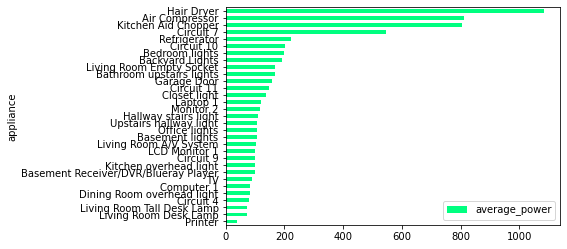

In [32]:
data_power_pandas.plot(kind='barh', x='appliance', y='average_power', colormap='winter_r')

#### Then, analyze the resistance of the different appliance

In [33]:
data_R = spark \
    .sql('select appliance, AVG(resistance)  AS average_R from data_all group by appliance order by AVG(resistance) ')

In [34]:
data_R.show()

+--------------------+------------------+
|           appliance|         average_R|
+--------------------+------------------+
|          Hair Dryer|  86.2254184754573|
|     Backyard Lights|302.67783590228083|
|          Circuit 10|417.49448107664006|
|Living Room Empty...|478.83275396903895|
|         Garage Door| 805.1406235880711|
|           Circuit 7| 900.8783708444986|
|      Bedroom lights|1186.3632908012717|
|Bathroom upstairs...|1314.7456596391064|
|      Air Compressor|1329.2982711622867|
|        Closet light| 1734.932669286012|
|          Circuit 11|1963.8850395792492|
|        Refrigerator|2037.3400720657792|
| Kitchen Aid Chopper|2052.2394195302754|
|            Laptop 1|2171.3997073885585|
|           Monitor 2|  2212.21731735702|
|Hallway stairs light| 2360.690259561637|
|     Basement lights|2403.0918078535888|
|       Office lights|2508.5773703054388|
|           Circuit 9|2573.2130374918856|
|                  TV| 2671.513275546197|
+--------------------+------------

In [35]:
data_R_pandas = data_R.toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


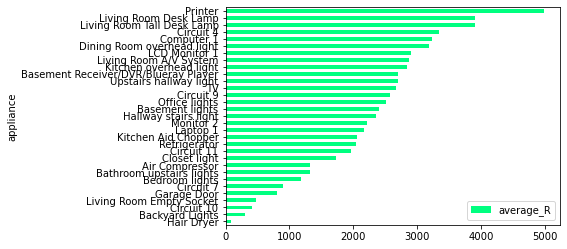

In [36]:
data_R_pandas.plot(kind='barh', x='appliance', y='average_R', colormap='winter_r')

#### Finally, analyze the using time of the different appliance

In [37]:
data_Freq = spark \
    .sql('select appliance, COUNT(appliance)  AS frequency from data_all group by appliance order by COUNT(appliance)  ')


In [38]:
data_Freq.show()

+--------------------+---------+
|           appliance|frequency|
+--------------------+---------+
| Kitchen Aid Chopper|    37200|
|Living Room Empty...|    37200|
|          Hair Dryer|    37200|
|     Backyard Lights|    74400|
|      Bedroom lights|    74400|
|            Laptop 1|   130200|
|Living Room A/V S...|   130200|
|      Air Compressor|   148800|
|Upstairs hallway ...|   186000|
|        Closet light|   186000|
|         Garage Door|   223200|
|Living Room Tall ...|   260400|
|Living Room Desk ...|   260400|
|           Circuit 7|   260400|
|Basement Receiver...|   260400|
|                  TV|   297600|
|     Basement lights|   297600|
|          Computer 1|   316200|
|           Circuit 4|   334800|
|Dining Room overh...|   372000|
+--------------------+---------+
only showing top 20 rows



In [39]:
data_Freq_pandas = data_Freq.toPandas()

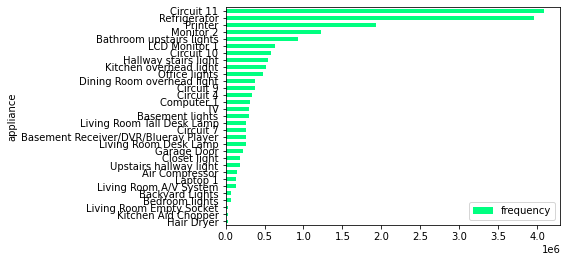

In [40]:
data_Freq_pandas.plot(kind='barh', x='appliance', y='frequency', colormap='winter_r')

## 4.Model Building

- Our target is building a prediction model to predict the appliance based on the other info


#### Data Preparation

In [41]:
data_model = data_all.drop('code')

In [42]:
data_model = data_model.drop('_c0')

In [43]:
data_model.show(4)

+------------+-------------------+---------+-------------------+---------+------------------+-----------------+------------------+
|     X_Value|          Current A|Current B|           VoltageA|appliance|             power|   Absolute_power|        resistance|
+------------+-------------------+---------+-------------------+---------+------------------+-----------------+------------------+
|39087.584083|0.33881999999999995| 0.054077|         -20.301841|Monitor 2|-6.878669767619999|6.878669767619999| 59.91925211026504|
|39087.584167|           0.381274|-0.051351|-15.000264999999999|Monitor 2|-5.719211037609999|5.719211037609999| 39.34248073563894|
| 39087.58425|           0.466182|-0.177866|          -9.446233|Monitor 2|-4.403663792405999|4.403663792405999|20.262972401336818|
|39087.584333|            0.55109|-0.283294|          -3.860644|Monitor 2|    -2.12756230196|    2.12756230196|  7.00546916111706|
+------------+-------------------+---------+-------------------+---------+---------

In [44]:
splitted_data = data_model.randomSplit([0.8, 0.18, 0.02], 24)
train_data = splitted_data[0]
test_data = splitted_data[1]
predict_data = splitted_data[2]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
print("Number of prediction records : " + str(predict_data.count()))

Number of training records: 15359206
Number of testing records : 3452888
Number of prediction records : 383106


#### Create pipeline and train model

In [45]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [46]:
stringIndexer_label = StringIndexer(inputCol="appliance", outputCol="label")#.fit(df_data)


In [47]:
si_label_fit = StringIndexer(inputCol="appliance", outputCol="label").fit(data_model)

In [48]:
si_label_fit.labels

['Circuit 11',
 'Refrigerator',
 'Printer',
 'Monitor 2',
 'Bathroom upstairs lights',
 'LCD Monitor 1',
 'Circuit 10',
 'Hallway stairs light',
 'Kitchen overhead light',
 'Office lights',
 'Dining Room overhead light',
 'Circuit 9',
 'Circuit 4',
 'Computer 1',
 'Basement lights',
 'TV',
 'Basement Receiver/DVR/Blueray Player',
 'Living Room Desk Lamp',
 'Circuit 7',
 'Living Room Tall Desk Lamp',
 'Garage Door',
 'Closet light',
 'Upstairs hallway light',
 'Air Compressor',
 'Living Room A/V System',
 'Laptop 1',
 'Bedroom lights',
 'Backyard Lights',
 'Kitchen Aid Chopper',
 'Living Room Empty Socket',
 'Hair Dryer']

In [49]:
#In the following step, create a feature vector by combining all string features together usinf the vectorAssembler method

vectorAssembler_features = VectorAssembler(
    inputCols=["X_Value", 
               "Current A", 
               "Current B", 
               "VoltageA",
              "power",
              "Absolute_power",
              "resistance"], 
    outputCol="features")

In [50]:
# Build the classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [51]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels=stringIndexer_label.fit(data_model).labels)

In [52]:
pipeline_rf = Pipeline(stages=[stringIndexer_label, 
                               vectorAssembler_features, 
                               rf, labelConverter])

In [53]:
train_data.printSchema()

root
 |-- X_Value: double (nullable = true)
 |-- Current A: double (nullable = true)
 |-- Current B: double (nullable = true)
 |-- VoltageA: double (nullable = true)
 |-- appliance: string (nullable = false)
 |-- power: double (nullable = true)
 |-- Absolute_power: double (nullable = true)
 |-- resistance: double (nullable = true)



In [54]:
model_rf = pipeline_rf.fit(train_data)

check my **model accuracy**. To evaluate the model, use **test data**

In [55]:
predictions = model_rf.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.463237
Test Error = 0.536763


In [56]:
predictions.show()

+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|           X_Value|          Current A|          Current B|           VoltageA|           appliance|              power|    Absolute_power|        resistance|label|            features|       rawPrediction|         probability|prediction|predictedLabel|
+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+------------------+-----+--------------------+--------------------+--------------------+----------+--------------+
|115821.23508299999|           1.251582|           0.096248| 49.691584999999996|Living Room Desk ...| 62.193093337469996|62.193093337469996| 39.70301985806763| 18.0|[115821.235082999...|[0.51211857121219...|[0.02560592856060...|       

In [57]:
spark.stop()

In [58]:
sc.stop()